# ACA-Py & ACC-Py Basic Template

## Copy this template into the root folder of your notebook workspace to get started

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://issuer-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and fill in additional logic as needed.

In [4]:
listeners = []

In [5]:
## YOUR LISTENERS HERE
# Receive connection messages
def connections_handler(payload):
    state = payload['state']
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]
    
    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")
    if state == "active":
        # Your business logic
        print(colored("Connection ID: {0} is now active.".format(connection_id), "green", attrs=["bold"]))

connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

listeners.append(connection_listener)

In [6]:
def issuer_handler(payload):
    connection_id = payload['connection_id']
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    print("\n---------------------------------------------------\n")
    print("Handle Issue Credential Webhook")
    print(f"Connection ID : {connection_id}")
    print(f"Credential exchange ID : {exchange_id}")
    print("Agent Protocol Role : ", role)
    print("Protocol State : ", state )
    print("\n---------------------------------------------------\n")
    
    
    if state == "offer_sent":
        proposal = payload["credential_proposal_dict"]
        attributes = proposal['credential_proposal']['attributes']

        print(f"Offering credential with attributes  : {attributes}")
        ## YOUR LOGIC HERE
    elif state == "request_received":
        print("Request for credential received")
        ## YOUR LOGIC HERE
    elif state == "credential_sent":
        print("Credential Sent")
        ## YOUR LOGIC HERE
    
issuer_listener = {
    "topic": "issue_credential",
    "handler": issuer_handler
}

listeners.append(issuer_listener)

In [7]:
agent_controller.register_listeners(listeners)

## Store Issuing Schema and Cred Def Identifiers

If you intend for this agent to issue credentials you should first initialise your agent as an issuer and author the relevant identifiers to the public ledger. The issuer_initialisation recipe notebook can be duplicated and used as a starting point.

Once schema and cred def identifiers are created copy across and store in variables as illustrated in the cell below. Be sure to use unique names for each variable.

In [8]:
schema_id='ABsZzHjqQSfKUCEquCaAkN:2:aries_playground:0.0.1'
cred_def_id='ABsZzHjqQSfKUCEquCaAkN:3:CL:9916:default'


# %store <schema_id>
# %store <cred_def_id>

## Load any Identifiers from Store

If you are writing your logic across multiple notebooks, which I have found can make it easier to break things up, then rather than defining the schema and cred def identifiers every time it can be easier to load them from the jupyter store. Note: this assumes they have been written to the store in a previous notebook during the time the current docker containers have been running.

In [ ]:
# %store -r <schema_id>
# %store -r <cred_def_id>

## Establish Connection with the Holder (PORT 8889)

Before you can issue a credential you must first establish a connection across which the credential will be issued to a holder. (see recipes/connection)

In [9]:
# Alias for invited connection
alias = None
auto_accept = "true"
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()



# You will use this identifier to issue a credential across this connection
connection_id = invitation_response["connection_id"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  77c0b816-5c82-4d8c-a8a7-bbdbfbabe5fe
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


## Copy Invitation Object to Holder Notebook

In [10]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': '0e502654-0258-4aee-93c3-386f16db826e', 'label': 'Issuer', 'serviceEndpoint': 'https://0751-86-18-68-143.ngrok.io', 'recipientKeys': ['HtSkAapeZfrzQvv66HAetE8uejEb6nPuxoUzVjSewBwL']}


## OPTIONAL: Display Invite as QR Code

This is useful if you wish to issue a credential to a mobile wallet.

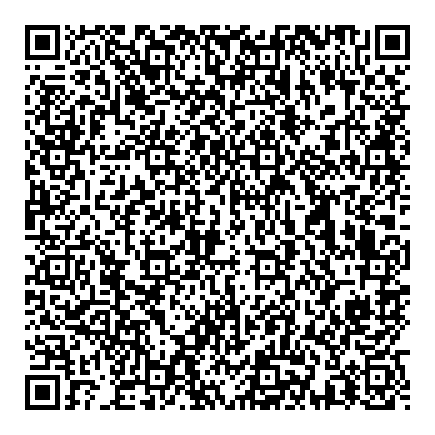

In [11]:
import qrcode
# Link for connection invitation
invitation_url = invitation_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

## Populate Credential Attributes

Before you can issue a credential, you must define the values that will be issued in this credential. The attribute names **MUST** match those in the schem identified by the <schema_id> value.

Make sure to change all code enclosed with <>.


In [15]:
comment=input("Please enter some comment: ")
credential_attributes = [
    {"name": "comment", "value": comment},
]
print(credential_attributes)

Please enter some comment:  Some comment


[{'name': 'comment', 'value': 'Some comment'}]


## Send Credential

This is the easiest way to issue a credential because it automates the rest of the protocol steps. 

Note: The `connection_id` must be in the active state before a credential can be sent.

In [16]:
# Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
trace = False
comment = ""
# Remove credential record after issued?
auto_remove = True

# Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
send_cred_response = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, comment, auto_remove, trace)

# Note last three args are optional.
# await agent_controller.issuer.send_credential(connection_id, <schema_id>, <cred_def_id, credential_attributes)


---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 6bbe8551-f056-49b4-9d12-839f67b5db5e
Credential exchange ID : e321550f-3e59-4c4a-8314-b3845141142e
Agent Protocol Role :  issuer
Protocol State :  offer_sent

---------------------------------------------------

Offering credential with attributes  : [{'name': 'comment', 'value': 'Some comment'}]

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 6bbe8551-f056-49b4-9d12-839f67b5db5e
Credential exchange ID : e321550f-3e59-4c4a-8314-b3845141142e
Agent Protocol Role :  issuer
Protocol State :  request_received

---------------------------------------------------

Request for credential received

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 6bbe8551-f056-49b4-9d12-839f67b5db5e
Credential exchange ID : e321550f-3e59-4c4a-8314-b3845141142e
Agent Protocol Role :  issuer
Protocol State : 

## Now Request a Proof of this Credential Through the Verifier Notebook (Port 8891)


## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [17]:
await agent_controller.terminate()